# CZ4042 Neural Networks & Deep Learning
## Assignment - 1: Part A, Question 3

> Gupta Jay  
> U1822549K  
> School of Computer Science and Engineering  
> Nanyang Technological University, Singapore  

## Imports

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
import pandas as pd
import numpy as np
import time

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [3]:
print(tf.__version__)

2.6.0


In [4]:
# Supress any warnings for clean presentation
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('./features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [6]:
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

Split and scale dataset

In [7]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [8]:
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


In [9]:
def getModel(neuron_size, first_layer_activation, second_layer_activation):
    # Inputs -> Dense -> Dropout -> Dense (Output)
    model = keras.Sequential()
    model.add(layers.Dense(neuron_size, activation=first_layer_activation, input_dim=X_train.shape[1]))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(df['label'].nunique(), activation=second_layer_activation))
    return model

def getOptimizer():
    # Adam Optimizer (Default Parameters) -> Stochastic Gradient Descent
    optimizer = keras.optimizers.Adam()
    return optimizer

## Part A: Search for the Optimal Number of Hidden Neurons

> Reference for K-Fold Cross Validation: https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

In [10]:
# Search Space
neuron_sizes = [8, 16, 32, 64]

# Hyperparameters
epochs = 50
n_splits = 3
verbose = 0
batch_size = 4
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
optimizer = getOptimizer()

histories = {} 

In [11]:
# 3-fold cross-validation on training partition
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)

In [12]:
# Experiment on neuron sizes
# Iterating through all neuron sizes
for neuron_size in neuron_sizes:
    neuron_specific_history = {}
    fold_counter = 1

    print("\nNumber of Neurons: %0.0f" % neuron_size)
    print("---------------")

    # Iterating through each split of training data
    for train, test in kfold.split(X_train, y_train):
        # Initialize model and fitting
        model = getModel(neuron_size, "relu", "softmax")
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        history = model.fit(X_train[train], y_train[train], batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_train[test], y_train[test]))
        
        print("Training Complete: Fold %0.0f" % fold_counter)
        
        # Storing history of every k-fold
        neuron_specific_history[fold_counter] = history
        fold_counter += 1

    # Storing history for every neuron size
    histories[neuron_size] = neuron_specific_history


Number of Neurons: 8
---------------


2021-10-13 23:07:47.547740: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-13 23:07:47.652905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Number of Neurons: 16
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Number of Neurons: 32
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3

Number of Neurons: 64
---------------
Training Complete: Fold 1
Training Complete: Fold 2
Training Complete: Fold 3


### Mean Cross-Validation Accuracies

In [13]:
accuracy_per_neuron_size = []

# Iterating through all the neuron sizes
for neuron_size in neuron_sizes:
    accuracy_per_epoch = []
    
    # Extract k-fold history for a neuron size
    neuron_size_histories = histories[neuron_size]

    # Calculate mean across 3-fold accuracies for each epoch
    for i in range(epochs):
        accuracies = [neuron_size_histories[1].history['val_accuracy'][i], neuron_size_histories[2].history['val_accuracy'][i], neuron_size_histories[3].history['val_accuracy'][i]]
        accuracy_per_epoch.append(np.mean(accuracies))

    # Store mean for each epoch, per neuron size  
    accuracy_per_neuron_size.append(accuracy_per_epoch)

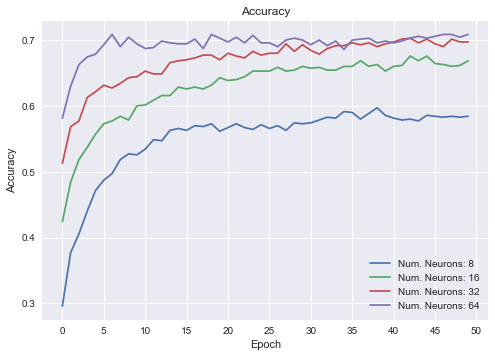

In [14]:
plt.style.use("seaborn")

# Plotting
for i in range(len(neuron_sizes)):
    plt.plot(accuracy_per_neuron_size[i])

# Labelling
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 50+1, 5.0))

# Legend for easy reading
plt.legend(['Num. Neurons: 8', 'Num. Neurons: 16', 'Num. Neurons: 32', 'Num. Neurons: 64'], loc='lower right')

## Part B: Select Optimal Number of Hidden Layer Neurons

**Optimal Number of Hidden Neurons**: `32`

Based on the graph plotted above, we observe that the accuracy converges approximately after `15` epochs for all number of neurons. Although the accuracues for model with `32` and `64` hidden neurons are close, we will consider the model with `32` neurons as it will be less complex and able to generalize better on real world data.

## Part C: Plot Train & Test Accuracies 

In [17]:
epochs = 50
verbose = 1

# Parameters for Optimal 2-layer network
batch_size = 4
neuron_size = 32

loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
optimizer = getOptimizer()

model = getModel(neuron_size, "relu", "softmax")
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose, batch_size=batch_size)

Epoch 1/50
175/175 [==============================] - 1s 2ms/step - loss: 2.3946 - accuracy: 0.1771 - val_loss: 1.8949 - val_accuracy: 0.3600
Epoch 2/50
175/175 [==============================] - 0s 849us/step - loss: 1.7538 - accuracy: 0.3729 - val_loss: 1.6143 - val_accuracy: 0.4633
Epoch 3/50
175/175 [==============================] - 0s 764us/step - loss: 1.5293 - accuracy: 0.4143 - val_loss: 1.4681 - val_accuracy: 0.5100
Epoch 4/50
175/175 [==============================] - 0s 765us/step - loss: 1.3900 - accuracy: 0.5114 - val_loss: 1.3583 - val_accuracy: 0.5567
Epoch 5/50
175/175 [==============================] - 0s 771us/step - loss: 1.2450 - accuracy: 0.5600 - val_loss: 1.2877 - val_accuracy: 0.5633
Epoch 6/50
175/175 [==============================] - 0s 766us/step - loss: 1.2054 - accuracy: 0.5586 - val_loss: 1.2347 - val_accuracy: 0.5900
Epoch 7/50
175/175 [==============================] - 0s 765us/step - loss: 1.1306 - accuracy: 0.5986 - val_loss: 1.1946 - val_accuracy: 0

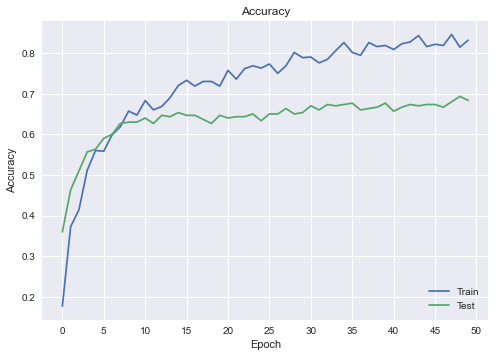

In [18]:
plt.style.use("seaborn")

# Extracting Train & Test Accuracy from model history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting
plt.plot(accuracy)
plt.plot(val_accuracy)

# Labelling
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 50+1, 5.0))

# Legend for easy reading
plt.legend(['Train', 'Test'], loc='lower right')

## Part D: Other Parameters for Tuning

There are several parameters that can be tuned. From the Train vs Test accuracies grapgh plotted above, we observe that after approximately `15` epochs, the test accuracy converges to `~70%`, whereas the train accuracy keeps increasing. This shows that there are still signs of overfitting in our model. 

We can tune the following parameters:
* **Number of Epochs** - The model accuracies may converge at later epochs.
* **Learning Rate** - The model accuracies may converge at lower/higher learnign rate.
* **Regularization** - Adding L1/L2 regularization may help to reduce overfitting.
* **Changing the model architecture** - May help to reduce overfitting.

## End of Part A, Question 3. 